In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


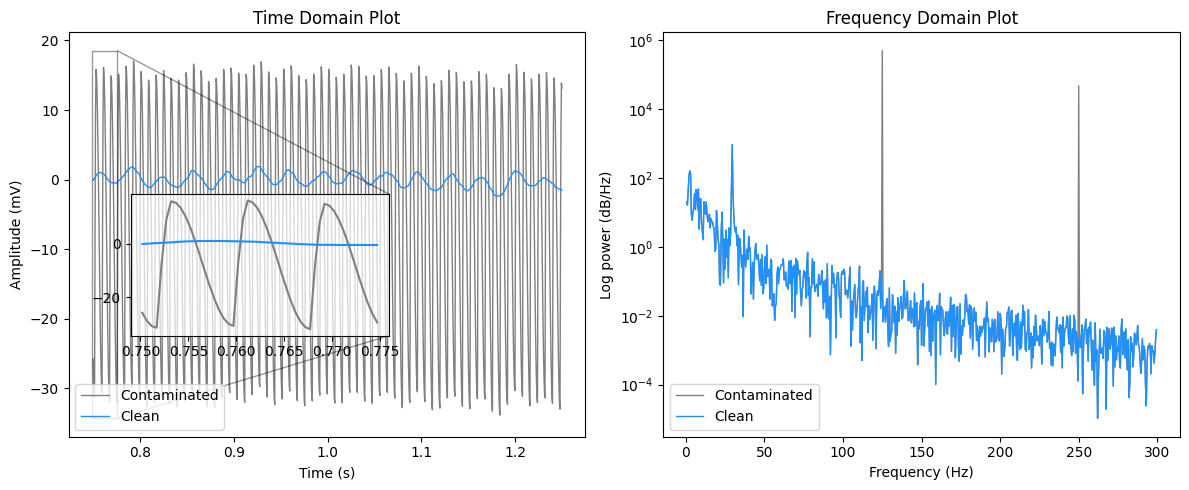

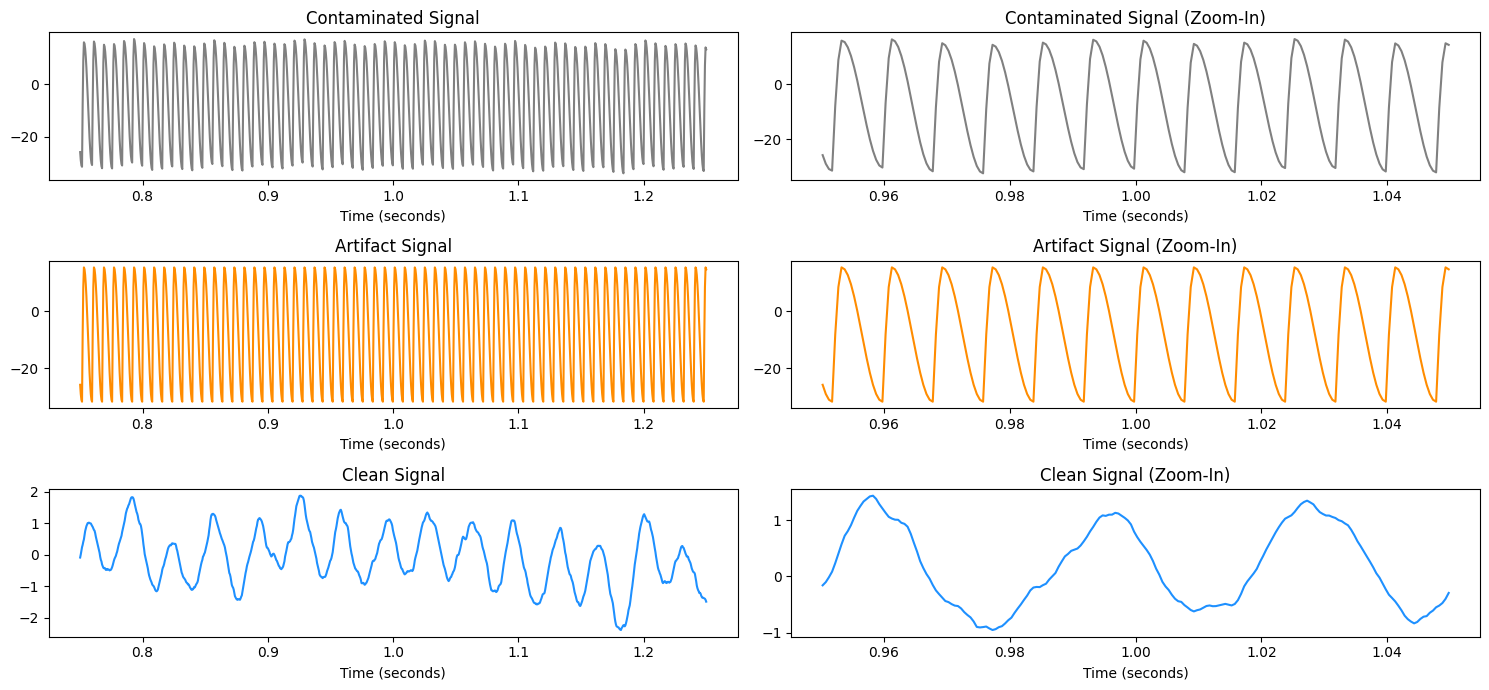

In [6]:
#fpath = "Test_data/"
fpath = "../../data/synthetic_data/1000_data/"
# fpath = "../data/synthetic_data/evaluation_data/"

Contaminated, Clean, Artifact = Data_Load_Plot(fpath)

fs=2000

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0, 4000)

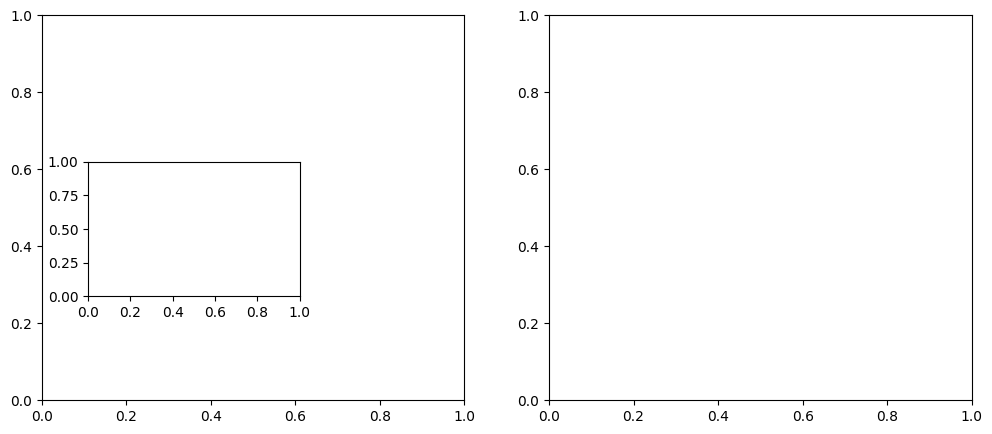

In [19]:

import numpy as np
from scipy.signal import iirnotch, filtfilt

# 노치 필터 설계 및 적용 함수
def notch_filter(data, notch_freqs, fs, quality_factor):
    Notched = data
    for notch_freq in notch_freqs:
        b, a = iirnotch(notch_freq, quality_factor, fs)
        Notched = filtfilt(b, a, Notched)
    return Notched

fundamental_freq = 125
harmonics = [fundamental_freq * i for i in range(1, int(fs/(2*fundamental_freq)) + 1)]  # 130Hz의 배수 계산

quality_factor = 30

Notched = notch_filter(Contaminated[0,:], harmonics, fs, quality_factor)

# 결과 Plot
save_path = '../result/evaluation/'
save_title = 'Notch'

Result_Plot(Contaminated, Notched, Clean) # inverse scaled data를 input으로 넣음
Result_Plot_paper(Contaminated, Notched, Clean, save_path, save_title) # inverse scaled data를 input으로 넣음

In [18]:
def Result_Plot(Contaminated, SACed, Clean, save_path=None, save_title=None, horizontal=True, small=False):

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error

    ### Time domain Plotting ###

    t = np.linspace(0, 2, num=4000) 
    start_time = 0.75; # [sec]
    end_time = 1.25; # [sec]
    fs = 2000
    start_pts = int(start_time*fs)
    end_pts = int(end_time*fs)

    if horizontal:
        if small:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            inset_axis = axes[0].inset_axes((0.06, 0.4, 0.3, 0.2))
        else: # large
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            inset_axis = axes[0].inset_axes((0.11, 0.27, 0.5, 0.35))
    else: # vertical
        if small:
            fig, axes = plt.subplots(2, 1, figsize=(3, 5))
            inset_axis = axes[0].inset_axes((0.06, 0.4, 0.3, 0.2))
        else: # large
            fig, axes = plt.subplots(2, 1, figsize=(5, 8))
            inset_axis = axes[0].inset_axes((0.11, 0.27, 0.5, 0.35))

    # main timeseries plot
    axes[0].plot(t[start_pts:end_pts], Contaminated[start_pts:end_pts], label="Contaminated", color="gray", alpha=1, linewidth=1)
    axes[0].plot(t[start_pts:end_pts], Clean[start_pts:end_pts], label="Clean", color='dodgerblue', alpha=1, linewidth=1)
    axes[0].plot(t[start_pts:end_pts], SACed[start_pts:end_pts], label="SACed", color='red', alpha=1, linewidth=1)
    axes[0].legend(prop={'size': 8}, loc='lower left')
    axes[0].set_xlabel("Time (s)"); axes[0].set_ylabel("Amplitude (mV)"); 
    axes[0].set_xlim(t[start_pts-20], t[end_pts+20])
    axes[0].set_title("Time Domain Plot")

    # zoom-in(x1) inset plot
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], Clean[0, start_pts + 400 : start_pts + 600], color='dodgerblue', linewidth=0.9)
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], SACed[0, start_pts + 400 : start_pts + 600], color='red', linewidth=0.9)
    #axes[0].indicate_inset_zoom(inset_axis, edgecolor="black", alpha=0.8, lw=1.2)
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], Contaminated[0, start_pts + 400 : start_pts + 600], color='gray', linewidth=0.8)
    #inset_axis.patch.set_alpha(1)
    #inset_axis.set_xlim(t[start_pts + 400-1], t[start_pts + 600])
    #min_val = min(Clean[0, start_pts + 400 : start_pts + 600].min(), SACed[0, start_pts + 400 : start_pts + 600].min())
    #max_val = max(Clean[0, start_pts + 400 : start_pts + 600].max(), SACed[0, start_pts + 400 : start_pts + 600].max())
    #inset_axis.set_ylim(min_val-0.2, max_val+0.2)

    ### Frequency domain Plottig ###  

    freqs, _, _, psd_Contaminated = FFT(Contaminated, fs=2000, single_sided=True)
    _, _, _, psd_Clean = FFT(Clean, fs=2000, single_sided=True)
    _, _, _, psd_SACed = FFT(SACed, fs=2000, single_sided=True)

    axes[1].semilogy(freqs[1:600], psd_Contaminated[1:600], label="Contaminated", color='gray', alpha = 1, linewidth=1)
    axes[1].semilogy(freqs[1:600], psd_Clean[1:600], label="Clean", color='dodgerblue', alpha = 1, linewidth=1)
    axes[1].semilogy(freqs[1:600], psd_SACed[1:600], label="SACed", color='red', alpha = 1, linewidth=1)
    axes[1].legend(prop={'size': 8}, loc='lower left')
    axes[1].set_xlabel("Frequency (Hz)"); axes[1].set_ylabel("Log power (dB/Hz)")
    axes[1].set_xlim(freqs[1]-5, freqs[600]+5)
    axes[1].set_title("Frequency Domain Plot")

    fig.tight_layout()

    if save_path != None and save_title != None:
        plt.savefig(save_path + save_title + "_fig" + ".png")# figure를 저장
    plt.show()

    ### MAE / MSE ###
    MSE_std(SACed, Clean, psd_SACed, psd_Clean, save_path, save_title)
